<a href="https://colab.research.google.com/github/Python-Is-Long/Teaching/blob/main/SHAP_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021-3-8

# SHAP value (SHapley Additive exPlanations)

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

## Marginal contributions of a feature

<img src="https://miro.medium.com/max/700/1*9oHGJ9kAMaUUEYtnfKKKEA.png"/>

> The gap between the predictions of two connected nodes can be imputed to the effect of that additional feature. This is called “marginal contribution” of a feature.

## Weighting

> The sum of the weights of all the marginal contributions to 1-feature-models should equal the sum of the weights of all the marginal contributions to 2-feature-models and so on. ($w₁ = w₂ + w₃ = w₄$)

> All the weights of marginal contributions to f-feature-models should equal to each other, for each f. ($w₂ = w₃$)

<img src="https://miro.medium.com/max/700/1*7keBLSQszepu5jITz8SKxA.png"/>

<img src="https://miro.medium.com/max/700/1*QpRB2gX5uJVU2cWRkrNvsA.png"/>

<img src="https://miro.medium.com/max/2400/1*wOLS6BO2vGTSB4sCoAb6fQ.png"/>

<img src="https://miro.medium.com/max/700/1*AwrLs6-GRrruYZ4euTUQmA.png"/>

<img src="https://miro.medium.com/max/700/1*U4yqx7idwCpWznTcP9Ntqg.png"/>

> Summing the SHAP values of each feature of a given observation yields the difference between the prediction of the model and the null model.

The original SHAP formula requires training 2 ^ F models (which is impossible for high dimensional data). So the practical calculation is done with approximation and sampling.

## Libraries:

SHAP: 
https://github.com/slundberg/shap

PyCaret:
https://pycaret.org/interpret-model/

Shapash:
https://github.com/MAIF/shapash

# Global functions

In [ ]:
!pip install shapash

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import re
from shapash.explainer.smart_explainer import SmartExplainer

# to make this notebook's output stable across runs
np.random.seed(10086)

def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced

from functools import wraps
import inspect
def initializer(func): #https://stackoverflow.com/questions/1389180/automatically-initialize-instance-variables
    names, varargs, keywords, defaults = inspect.getfullargspec(func)[:4]
    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)
    return wrapper

def get_feature_names(column_transformer, pipeline_prefix=False): #https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
  from sklearn.pipeline import Pipeline
  import warnings
  """Get feature names from all transformers.
  Returns
  -------
  feature_names : list of strings
    Names of the features produced by transform.
  """
  # Remove the internal helper function
  #check_is_fitted(column_transformer)
  # Turn loopkup into function for better handling with pipeline later
  def get_names(trans, columns=None):
    # >> Original get_feature_names() method
    if trans == 'drop' or (
        hasattr(column, '__len__') and not len(column)):
      return []
    if trans == 'passthrough':
      if hasattr(column_transformer, '_df_columns'):
        if ((not isinstance(column, slice))
            and all(isinstance(col, str) for col in column)):
          return column
        else:
          return column_transformer._df_columns[column]
      else:
        indices = np.arange(column_transformer._n_features)
        return ['x%d' % i for i in indices[column]]
    if not hasattr(trans, 'get_feature_names'):
    # >>> Change: Return input column names if no method avaiable
      # Turn error into a warning
      warnings.warn("Transformer %s (type %s) does not "
                 "provide get_feature_names. "
                 "Will return input column names if available"
                 % (str(name), type(trans).__name__))
      # For transformers without a get_features_names method, use the input
      # names to the column transformer
      if column is None:
        return []
      else:
        return [PREFIX + f for f in column]
    return [PREFIX + f for f in trans.get_feature_names(columns)]
  ### Start of processing
  feature_names = []
  # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
  if type(column_transformer) == Pipeline:
    l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
  else:
    # For column transformers, follow the original method
    l_transformers = list(column_transformer._iter(fitted=True))
  for name, trans, column, _ in l_transformers: 
    PREFIX = (name + "__")*pipeline_prefix
    if type(trans) == Pipeline:
      # Recursive call on pipeline
      _names = get_feature_names(trans)
      # if pipeline has no transformer that returns names
      if len(_names)==0:
        _names = [PREFIX + f for f in column]
      feature_names.extend(_names)
    else:
      feature_names.extend(get_names(trans, column))
  return feature_names

# Load toy data

In [ ]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


# Choose X and y

In [ ]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

X = df[columns_predictors]
y = df[TARGET]
display(X)
display(y)

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100


ID
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: default payment next month, Length: 30000, dtype: int64

# Train-test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

display(X_train)
display(y_train)

X_train.shape: (22500, 23)
X_test.shape: (7500, 23)
y_train.shape: (22500,)
y_test.shape: (7500,)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
17778,70000,2,3,2,55,0,0,0,0,0,0,4664,5680,6703,7853,7316,7350,1100,1123,1273,407,300,300
11181,190000,2,2,1,45,2,0,0,0,0,0,140329,128107,131132,96083,97453,99426,6800,7000,3585,3700,3754,7900
18834,70000,2,2,2,24,0,0,0,0,0,0,34201,49800,26194,27454,28159,25775,1800,2000,2000,1500,1500,0
19424,150000,2,1,2,31,0,0,0,-1,0,0,10778,6798,6221,4711,6711,6711,6000,3039,9050,2000,0,4000
15760,130000,2,2,2,22,2,2,2,2,0,0,29929,27812,21213,15443,25371,4264,3412,1700,0,15571,4264,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,180000,1,2,2,43,0,0,0,0,0,0,164222,169073,171820,160018,164717,151235,7500,5900,6000,7000,7000,5000
21159,180000,1,2,2,39,0,0,0,0,0,0,119466,120491,124553,127096,128992,131660,4500,6000,6100,5500,4900,5500
15009,30000,1,3,1,43,1,3,2,2,2,2,22494,21845,21207,23491,22818,24321,0,0,2645,0,2029,1027


ID
17778    0
11181    0
18834    0
19424    0
15760    0
        ..
14526    0
21159    0
15009    1
26564    0
21191    0
Name: default payment next month, Length: 22500, dtype: int64

# Feature Engineering

In [ ]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #specific transformations we want to use in our pipelines

pipeline_full = ColumnTransformer(transformers=[
  ("categorical", OneHotEncoder(), columns_categorical),
  # ("numerical", MinMaxScaler(), columns_numerical), #Shapash doesn't support this transformer??? WTF
],
  remainder='passthrough',
)

In [ ]:
%%time
pipeline_full.fit(X_train, y_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

feature_names = get_feature_names(pipeline_full, pipeline_prefix=False)
X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=feature_names, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed.toarray(), columns=feature_names, index=X_test.index)
display(X_train_transformed)
display(X_test_transformed)

X_train_transformed.shape: (22500, 91)
X_test_transformed.shape: (7500, 91)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,...,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17778,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,55.0,4664.0,5680.0,6703.0,7853.0,7316.0,7350.0,1100.0,1123.0,1273.0,407.0,300.0,300.0
11181,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0,45.0,140329.0,128107.0,131132.0,96083.0,97453.0,99426.0,6800.0,7000.0,3585.0,3700.0,3754.0,7900.0
18834,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,24.0,34201.0,49800.0,26194.0,27454.0,28159.0,25775.0,1800.0,2000.0,2000.0,1500.0,1500.0,0.0
19424,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150000.0,31.0,10778.0,6798.0,6221.0,4711.0,6711.0,6711.0,6000.0,3039.0,9050.0,2000.0,0.0,4000.0
15760,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130000.0,22.0,29929.0,27812.0,21213.0,15443.0,25371.0,4264.0,3412.0,1700.0,0.0,15571.0,4264.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,43.0,164222.0,169073.0,171820.0,160018.0,164717.0,151235.0,7500.0,5900.0,6000.0,7000.0,7000.0,5000.0
21159,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,39.0,119466.0,120491.0,124553.0,127096.0,128992.0,131660.0,4500.0,6000.0,6100.0,5500.0,4900.0,5500.0
15009,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,...,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210000.0,35.0,1338.0,1508.0,1409.0,1549.0,2454.0,946.0,1508.0,1409.0,1549.0,2454.0,946.0,1525.0
279,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,33.0,50859.0,50462.0,50654.0,20046.0,20067.0,19703.0,2007.0,2199.0,691.0,707.0,703.0,697.0
9429,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,29.0,40117.0,45598.0,44570.0,47133.0,46249.0,47179.0,6138.0,0.0,3618.0,0.0,1850.0,1862.0
12192,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10000.0,55.0,420.0,420.0,420.0,420.0,420.0,420.0,0.0,0.0,0.0,0.0,0.0,780.0
6262,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240000.0,28.0,209848.0,214477.0,218142.0,195913.0,197823.0,189111.0,10000.0,9000.0,7000.0,7000.0,6625.0,7000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26522,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,52.0,1000.0,1098.0,28229.0,28046.0,24446.0,22151.0,1098.0,30005.0,1350.0,800.0,750.0,780.0
1746,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,22.0,49459.0,49281.0,50071.0,10104.0,9208.0,10075.0,2300.0,2000.0,1000.0,500.0,1000.0,500.0
7731,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,53.0,4794.

CPU times: user 527 ms, sys: 5.81 ms, total: 533 ms
Wall time: 535 ms


# Machine Learning

In [ ]:
%%time
# from sklearn.linear_model import LogisticRegression
# model_lr = LogisticRegression(n_jobs=-1, random_state=10086).fit(X_train_transformed, y_train)
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_estimators=200, n_jobs=-1).fit(X_train_transformed, y_train)

CPU times: user 10.7 s, sys: 10.3 ms, total: 10.7 s
Wall time: 10.7 s


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model_xgb.predict(X_test_transformed)
y_pred_proba = model_xgb.predict_proba(X_test_transformed) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"precision_score: {precision_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

accuracy_score: 0.8162666666666667
precision_score: 0.6666666666666666
recall_score: 0.3387582881253767
f1_score: 0.4492406075139888
roc_auc_score: 0.7760682704900683


# Shapash

In [ ]:
xpl = SmartExplainer()
xpl.compile(
    x=X_test_transformed,
    y_pred=y_test,
    preprocessing=pipeline_full,
    model=model_xgb,
)

Backend: Shap TreeExplainer


## Dashboard functionality for Google Colab

Run this cell first and then run xpl.run_app(). Then click the link displayed at the bottom of this cell.

In [ ]:
### Install ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

### Run ngrok to tunnel Dash app port 8050 to the outside world. 
### This command runs in the background.
get_ipython().system_raw('./ngrok http 8050 &')

### Get the public URL where you can access the Dash app. Copy this URL.
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-03-08 15:39:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.171.215.128, 34.195.37.70, 107.21.11.91, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.171.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  51.2MB/s    in 0.3s    

2021-03-08 15:39:20 (51.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://59c7ee60def6.ngrok.io


In [ ]:
app = xpl.run_app()

Dash is running on http://0.0.0.0:8050/



INFO:root:Your Shapash application run on http://0dcbbc59ca5a:8050/


Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)


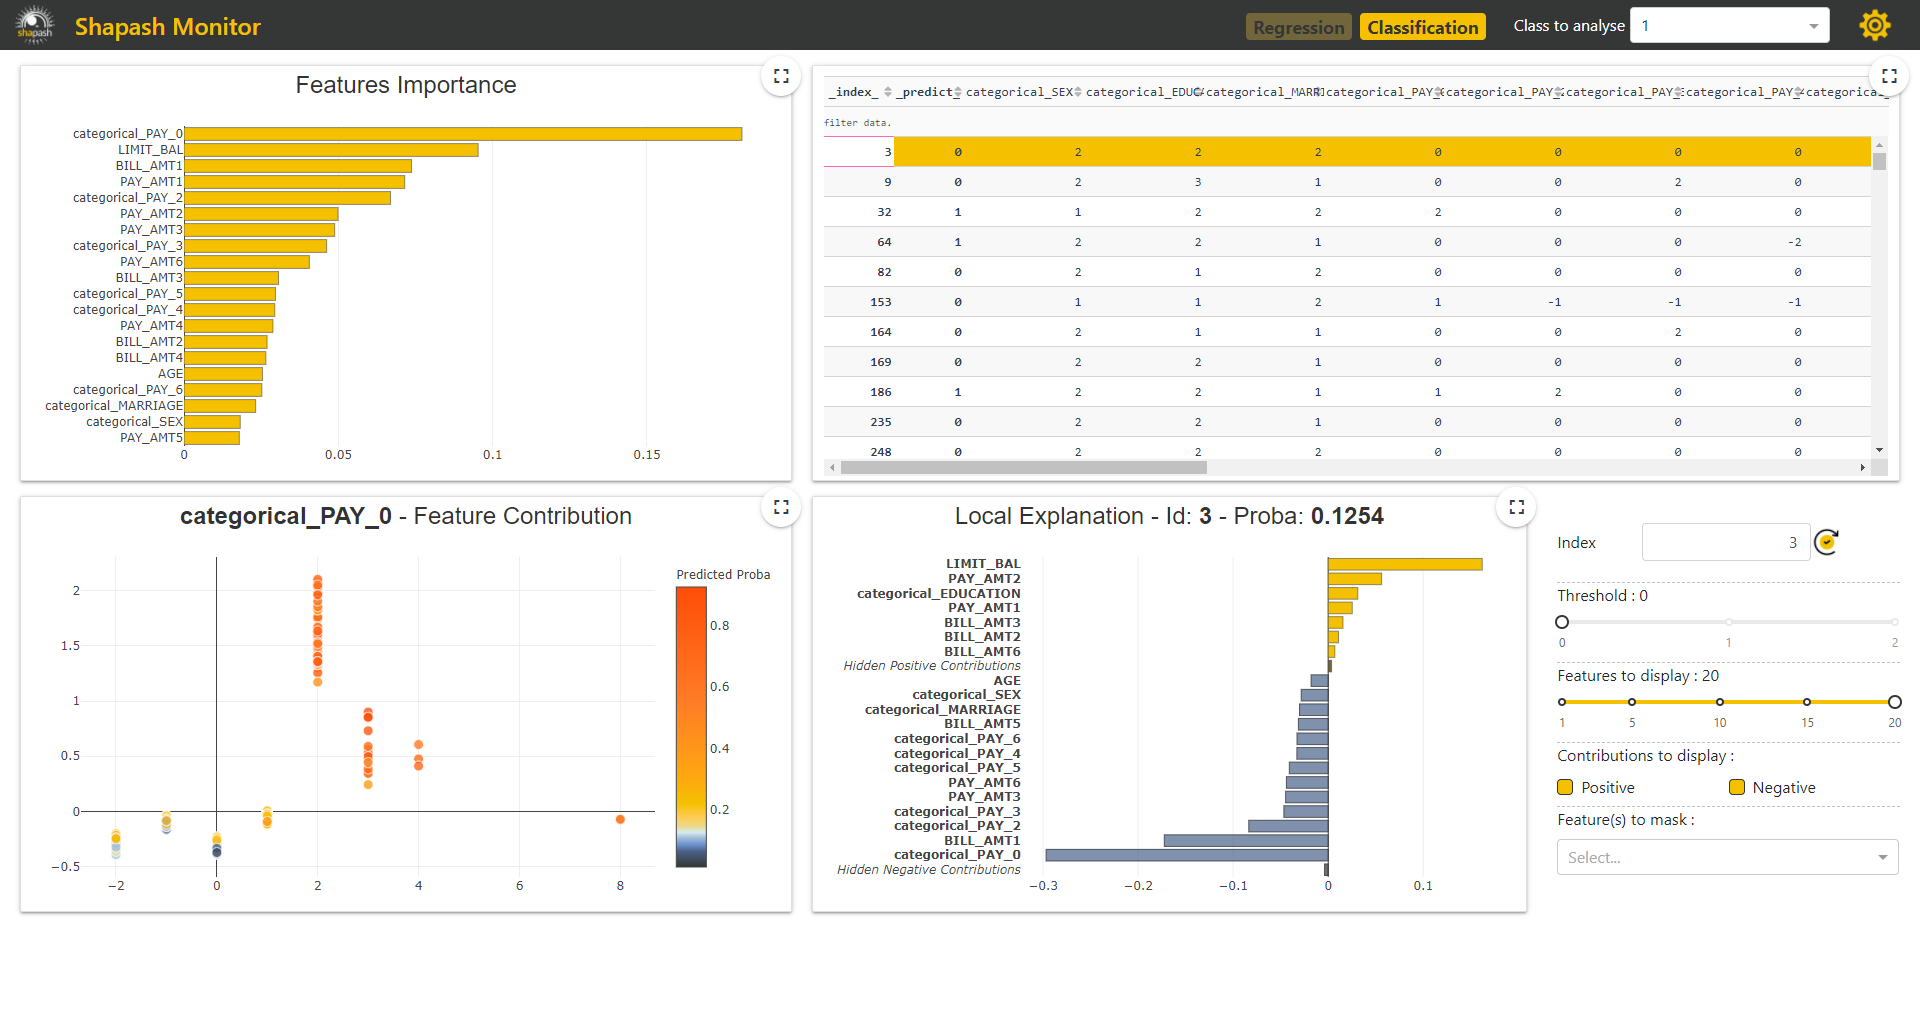

In [ ]:
app.kill()